# gowpy: README.md examples

## Building a Graph-of-Words from a Document

In [1]:
from gowpy.gow.builder import GoWBuilder

In [2]:
builder = GoWBuilder(directed=True, 
                     window_size=4)

In [3]:
text = """gowpy is a simple framework for exploiting graph-of-words in nlp gowpy 
leverages graph-of-words representation for document classification and for keyword extraction 
from a document"""
# ...
preprocessed_text = """gowpy simple framework exploiting graph-of-words nlp gowpy 
leverages graph-of-words representation document classification keyword extraction document"""

In [4]:
gow = builder.compute_gow_from_document(text)

In [5]:
gow

Graph-of-words
Nodes: ['gowpy', 'is', 'a', 'simple', 'framework', 'for', 'exploiting', 'graph-of-words', 'in', 'nlp', 'leverages', 'representation', 'document', 'classification', 'and', 'keyword', 'extraction', 'from']
Edges: ['framework__graph-of-words', 'is__simple', 'exploiting__nlp', 'leverages__representation', 'for__exploiting', 'gowpy__a', 'graph-of-words__document', 'in__gowpy', 'extraction__document', 'for__classification', 'gowpy__graph-of-words', 'extraction__a', 'in__nlp', 'document__for', 'keyword__extraction', 'gowpy__leverages', 'a__document', 'graph-of-words__representation', 'a__for', 'gowpy__simple', 'for__in', 'is__a', 'extraction__from', 'nlp__gowpy', 'exploiting__graph-of-words', 'and__for', 'representation__for', 'leverages__graph-of-words', 'document__classification', 'for__document', 'in__leverages', 'from__a', 'gowpy__representation', 'simple__exploiting', 'simple__framework', 'nlp__graph-of-words', 'representation__classification', 'document__and', 'framework_

In [6]:
import matplotlib.pyplot as plt
import networkx as nx

In [7]:
g = gow.to_labeled_graph()

In [8]:
options = {
    "font_weight" : 'normal',
    "font_color" : 'darkblue',
    #
    "edge_color" : 'lightgray',
    #
    "node_size" : 200,
    "node_color": 'white',
    "with_labels": True,
}

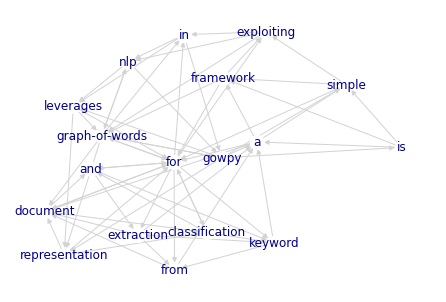

In [9]:
nx.draw(g, **options)

## Unsupervised Keywords Extraction

In [10]:
from gowpy.summarization.unsupervised import GoWKeywordExtractor

In [11]:
extractor_kw = GoWKeywordExtractor(directed=False, window_size=4)

In [12]:
preprocessed_text = """gowpy simple framework exploiting graph-of-words nlp gowpy 
leverages graph-of-words representation document classification keyword extraction 
document"""
len(preprocessed_text.split())

15

In [13]:
extractor_kw.extract(preprocessed_text)

[('gowpy', 4),
 ('simple', 4),
 ('framework', 4),
 ('exploiting', 4),
 ('graph-of-words', 4),
 ('nlp', 4)]

## Classification with TW-IDF: a graph-based term weighting score

In [14]:
from gowpy.feature_extraction.gow import TwidfVectorizer

In [15]:
corpus = [
    'hello world !',
    'foo bar'
]

In [16]:
vectorizer_gow = TwidfVectorizer(                 
    # Graph-of-words specificities
    directed=True,
    window_size=4,
    # Token frequency filtering
    min_df=0.0,
    max_df=1.0,
    # Graph-based term weighting approach
    term_weighting='degree'
)

X = vectorizer_gow.fit_transform(corpus)

In [17]:
X.toarray()

array([[0.89442719, 0.        , 0.        , 0.        , 0.4472136 ],
       [0.        , 1.        , 0.        , 0.        , 0.        ]])

In [18]:
X

<2x5 sparse matrix of type '<class 'numpy.float64'>'
	with 3 stored elements in Compressed Sparse Row format>

In [19]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV

pipeline = Pipeline([
    ('gow', TwidfVectorizer()),
    ('svm', SVC()),
])

parameters = {
    'gow__directed' : [True, False],
    'gow__window_size' : [2, 4, 8, 16],
    'gow__b' : [0.0, 0.003],
    'gow__term_weighting' : ['degree', 'pagerank'],
    'gow__min_df' : [0, 5, 10],
    'gow__max_df' : [0.8, 0.9, 1.0],
#
    'svm__C' : [0.1, 1, 10],
    'svm__kernel' : ['linear']
}

# find the best parameters for both the feature extraction and the
# classifier
grid_search = GridSearchCV(pipeline, 
                           parameters, 
                           cv=10,
                           n_jobs=-1)

## Going further: classification based on frequent subgraphs

### Conversion of the corpus into a collection of graph-of-words

In [20]:
from gowpy.gow.miner import GoWMiner
import gowpy.gow.io

In [21]:
corpus = [
    'hello world !',
    'foo bar',
    # and many more...
]

In [22]:
gow_miner = GoWMiner(directed=False, window_size=4)
corpus_gows = gow_miner.compute_gow_from_corpus(corpus)

In [23]:
with open("corpus_gows.data", "w") as f_output:
    data = gowpy.gow.io.gow_to_data(corpus_gows)
    f_output.write(data)

### Mining the frequent subgraphs

In [24]:
gow_miner.load_graphs('gbolt-mining-corpus_gow.t0', 
                      'gbolt-mining-corpus_gow.nodes')
gow_miner

Graph-of-word miner:
        - is_directed: False
        - window_size: 4
        - edge_labeling: True

        - Number of tokens: 5
        - Number of links between tokens: 4

        - Number of loaded subgraph: 13
        

### Classification with frequent subgraphs

In [25]:
import pandas as pd
s_freq_per_pattern = pd.Series(gow_miner.stat_relative_freq_per_pattern())
s_freq_per_pattern.describe()

count    13.0
mean      0.5
std       0.0
min       0.5
25%       0.5
50%       0.5
75%       0.5
max       0.5
dtype: float64

In [26]:
from gowpy.feature_extraction.gow import GoWVectorizer

vectorizer_gow = GoWVectorizer(gow_miner)
X = vectorizer_gow.fit_transform(corpus)
X

<2x13 sparse matrix of type '<class 'numpy.int64'>'
	with 13 stored elements in Compressed Sparse Row format>

In [27]:
feature_names = vectorizer_gow.get_feature_names()

In [28]:
features = [feature for presence, feature in zip(X.toarray()[0], feature_names) if presence > 0]
print("Nombre de features: {}".format(len(features)))
for feature in features:
    print(f'\t- {feature}')

Nombre de features: 10
	- hello world hello__world
	- hello world ! world__! hello__world
	- hello world ! world__! hello__world hello__!
	- hello world ! hello__world hello__!
	- hello ! hello__!
	- hello world ! world__! hello__!
	- world ! world__!
	- hello
	- !
	- world


In [29]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.model_selection import GridSearchCV

In [30]:
pipeline = Pipeline([
    ('gow', GoWVectorizer(gow_miner)),
    ('tfidf', TfidfTransformer()),
    ('svm', SVC()),
])

parameters = {
    'gow__subgraph_matching' : ['partial', 'induced'],
    'gow__min_df' : [0.00833, 0.01, 0.013333],
    'gow__max_df' : [0.022778, 0.25, 0.5, 1.0],
#
    'svm__C' : [0.1, 1, 10],
    'svm__kernel' : ['linear']
}

# find the best parameters for both the feature extraction and the
# classifier
grid_search = GridSearchCV(pipeline, 
                           parameters, 
                           cv=10,
                           n_jobs=-1)